In [6]:
!pip install imbalanced-learn


In [21]:
import mlflow
print("Current tracking URI:", mlflow.get_tracking_uri())


Current tracking URI: http://localhost:5000


In [22]:
mlflow.set_tracking_uri("http://localhost:5000")


# Import libraries 

In [15]:
import pandas as pd
from IPython.display import display
import logging
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import logging
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import mlflow
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import mlflow.sklearn

# Create a folder for the models and Plots  !

In [8]:
import os
os.makedirs("C:/Users/HP/10 Acadamy PRojects/New folder (5)/Altdata-lending-risk-model/plots", exist_ok=True)
os.makedirs("C:/Users/HP/10 Acadamy PRojects/New folder (5)/Altdata-lending-risk-model/api/model", exist_ok=True)


# Load Data 

In [9]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

DATA_PATH = 'C:/Users/HP/10 Acadamy PRojects/New folder (5)/Altdata-lending-risk-model/data/credit_risk_woe_mapped.csv'  


# Loading WoE-Transformed Data

In [10]:
logger.info('Loading WoE-transformed data')
try:
    df = pd.read_csv(DATA_PATH)
    logger.info(f'Dataset loaded with shape: {df.shape}')
    display(df.head())

    # Select features: WoE-transformed and high-correlation numeric features
    woe_features = ['Recency_Bin_WoE', 'Frequency_Bin_WoE', 'Monetary_Bin_WoE']
    numeric_features = ['PricingStrategy', 'TotalTransactionAmount', 'TransactionMonth', 'TransactionYear']
    features = woe_features + numeric_features

    # Verify features exist
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        logger.error(f'Missing features: {missing_features}')
        raise ValueError(f'Missing features: {missing_features}')

    X = df[features]
    y = df['Good_Bad']
    logger.info(f'Selected features: {features}')
    logger.info(f'Target distribution:\n{y.value_counts(normalize=True)}')
    display(X.head())

except Exception as e:
    logger.error(f'Error loading data: {str(e)}')
    raise


INFO:__main__:Loading WoE-transformed data


INFO:__main__:Dataset loaded with shape: (95662, 40)


,index,TransactionId,CustomerId,Amount,TransactionStartTime,PricingStrategy,FraudResult,TotalTransactionAmount,AverageTransactionAmount,TotalTransactions,...,Monetary,RFMS_Label,User_Label,Good_Bad,Recency_Bin,Frequency_Bin,Monetary_Bin,Recency_Bin_WoE,Frequency_Bin_WoE,Monetary_Bin_WoE
0,0,TransactionId_76871,CustomerId_4406,1000.0,2018-11-15 02:18:49+00:00,2,0,109921.75,923.712185,-0.311831,...,109921.75,1,Bad,1,9,5,3,21.412951,-0.691533,21.460170
1,1,TransactionId_73770,CustomerId_4406,-20.0,2018-11-15 02:19:08+00:00,2,0,109921.75,923.712185,-0.311831,...,109921.75,1,Bad,1,9,5,3,21.412951,-0.691533,21.460170
2,2,TransactionId_26203,CustomerId_4683,500.0,2018-11-15 02:44:21+00:00,2,0,1000.00,500.000000,-0.444993,...,1000.00,1,Bad,1,9,0,0,21.412951,21.458399,21.456729
3,3,TransactionId_380,CustomerId_988,20000.0,2018-11-15 03:32:55+00:00,2,0,228727.20,6019.136842,-0.404020,...,228727.20,1,Bad,1,9,2,5,21.412951,21.469909,-0.446438
4,4,TransactionId_28195,CustomerId_988,-644.0,2018-11-15 03:34:21+00:00,2,0,228727.20,6019.136842,-0.404020,...,228727.20,1,Bad,1,9,2,5,21.412951,21.469909,-0.446438


INFO:__main__:Selected features: ['Recency_Bin_WoE', 'Frequency_Bin_WoE', 'Monetary_Bin_WoE', 'PricingStrategy', 'TotalTransactionAmount', 'TransactionMonth', 'TransactionYear']
INFO:__main__:Target distribution:
Good_Bad
1    0.821329
0    0.178671
Name: proportion, dtype: float64


,Recency_Bin_WoE,Frequency_Bin_WoE,Monetary_Bin_WoE,PricingStrategy,TotalTransactionAmount,TransactionMonth,TransactionYear
0,21.412951,-0.691533,21.460170,2,109921.75,11,2018
1,21.412951,-0.691533,21.460170,2,109921.75,11,2018
2,21.412951,21.458399,21.456729,2,1000.00,11,2018
3,21.412951,21.469909,-0.446438,2,228727.20,11,2018
4,21.412951,21.469909,-0.446438,2,228727.20,11,2018


In [27]:
# Split into 80% training and 20% testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

logger.info(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')
logger.info(f'Train target distribution:\n{y_train.value_counts(normalize=True)}')


INFO:__main__:Train shape: (76529, 7), Test shape: (19133, 7)
INFO:__main__:Train target distribution:
Good_Bad
1    0.821336
0    0.178664
Name: proportion, dtype: float64


##  Handle Class Imbalance  



In [ ]:

logger.info('Applying SMOTE to balance training data')
try:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    logger.info(f'Resampled training set shape: {X_resampled.shape}')
    logger.info(f'Resampled target distribution:\n{pd.Series(y_resampled).value_counts(normalize=True)}')
except Exception as e:
    logger.error(f'Error applying SMOTE: {str(e)}')
    raise


INFO:__main__:Applying SMOTE to balance training data
INFO:__main__:Resampled training set shape: (125712, 7)
INFO:__main__:Resampled target distribution:
Good_Bad
1    0.5
0    0.5
Name: proportion, dtype: float64


## Define and Train Models  

In [14]:
logger.info('Starting model training')

# Define models and hyperparameter grids
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'LogisticRegression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'DecisionTree': {'classifier__max_depth': [3, 5, 7, None]},
    'RandomForest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [5, 10, None]},
    'GradientBoosting': {'classifier__learning_rate': [0.01, 0.1, 0.2], 'classifier__n_estimators': [50, 100, 200]}
}

# Initialize result containers
grid_searches = {}
performance_metrics = {}
best_model_name = None
best_roc_auc = 0

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        logger.info(f'Training {name}')
        try:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])

            grid_search = GridSearchCV(
                pipeline, param_grids[name],
                cv=5, scoring='roc_auc', n_jobs=-1
            )
            grid_search.fit(X_resampled, y_resampled)

            # Log best params and metrics
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metric('best_cv_roc_auc', grid_search.best_score_)

            # Evaluate
            y_pred = grid_search.predict(X_test)
            y_prob = grid_search.predict_proba(X_test)[:, 1]

            metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, zero_division=0),
                'recall': recall_score(y_test, y_pred, zero_division=0),
                'f1_score': f1_score(y_test, y_pred, zero_division=0),
                'roc_auc': roc_auc_score(y_test, y_prob)
            }

            performance_metrics[name] = metrics
            for metric, value in metrics.items():
                mlflow.log_metric(metric, value)

            mlflow.sklearn.log_model(grid_search.best_estimator_, f'{name}_model')

            if metrics['roc_auc'] > best_roc_auc:
                best_roc_auc = metrics['roc_auc']
                best_model_name = name
                mlflow.sklearn.log_model(grid_search.best_estimator_, 'best_model')

            grid_searches[name] = grid_search
            logger.info(f'{name} trained with ROC AUC: {metrics["roc_auc"]:.4f}')
            print(f'{name} - Best Params: {grid_search.best_params_}, Test ROC AUC: {metrics["roc_auc"]:.4f}')
        
        except Exception as e:
            logger.error(f'Error training {name}: {str(e)}')
            raise


INFO:__main__:Starting model training
INFO:__main__:Training LogisticRegression
2025/06/29 15:33:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/29 15:34:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/29 15:34:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/29 15:34:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:__main__:LogisticRegression trained with ROC AUC: 1.0000


LogisticRegression - Best Params: {'classifier__C': 0.01}, Test ROC AUC: 1.0000


INFO:__main__:Training DecisionTree
2025/06/29 15:34:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/29 15:34:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/29 15:35:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/29 15:35:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:__main__:DecisionTree trained with ROC AUC: 1.0000


DecisionTree - Best Params: {'classifier__max_depth': 3}, Test ROC AUC: 1.0000


INFO:__main__:Training RandomForest
2025/06/29 15:37:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/29 15:37:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:__main__:RandomForest trained with ROC AUC: 1.0000


RandomForest - Best Params: {'classifier__max_depth': 5, 'classifier__n_estimators': 50}, Test ROC AUC: 1.0000


INFO:__main__:Training GradientBoosting
2025/06/29 15:41:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/29 15:41:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:__main__:GradientBoosting trained with ROC AUC: 1.0000


GradientBoosting - Best Params: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50}, Test ROC AUC: 1.0000


# Evaluate Models  

INFO:__main__:Evaluating models


,accuracy,precision,recall,f1_score,roc_auc
LogisticRegression,1.0,1.0,1.0,1.0,1.0
DecisionTree,1.0,1.0,1.0,1.0,1.0
RandomForest,1.0,1.0,1.0,1.0,1.0
GradientBoosting,1.0,1.0,1.0,1.0,1.0


INFO:__main__:Model performance saved to ../data/model_performance.csv


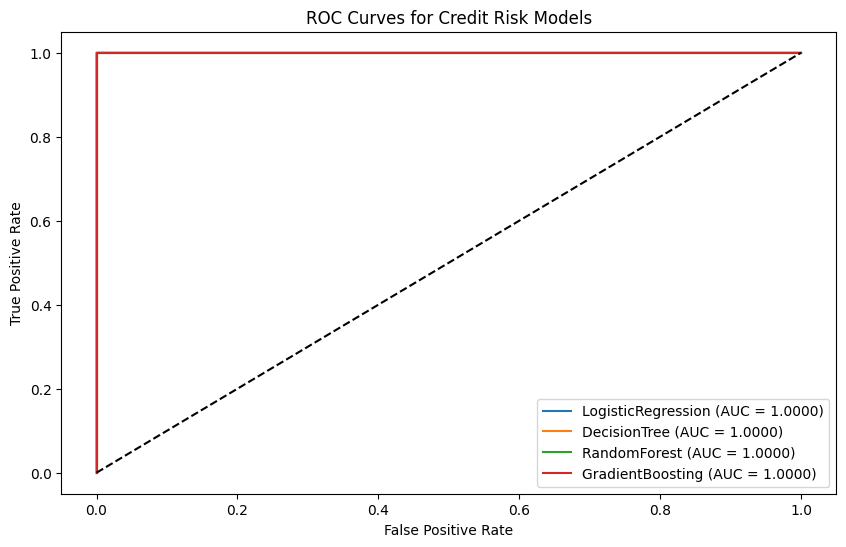

INFO:__main__:ROC curves saved to ../plots/roc_curves.png


In [16]:
logger.info('Evaluating models')
try:
    # Create DataFrame of performance metrics and display
    performance_df = pd.DataFrame(performance_metrics).T
    display(performance_df)
    
    # Save performance metrics to CSV
    performance_df.to_csv('../data/model_performance.csv')
    logger.info('Model performance saved to ../data/model_performance.csv')

    # Plot ROC curves for all models
    plt.figure(figsize=(10, 6))
    for name in models:
        y_prob = grid_searches[name].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {performance_metrics[name]["roc_auc"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Credit Risk Models')
    plt.legend()
    plt.savefig('../plots/roc_curves.png')
    plt.show()
    logger.info('ROC curves saved to ../plots/roc_curves.png')

except Exception as e:
    logger.error(f'Error evaluating models: {str(e)}')
    raise


In [20]:
mlflow.set_tracking_uri("http://localhost:5000")


# Register Best Model

In [25]:
import mlflow
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
# (Train your model here)

with mlflow.start_run() as run:
    run_id = run.info.run_id
    # Log the model artifact under name 'best_model'
    mlflow.sklearn.log_model(model, artifact_path="best_model")
    print(f"Model logged in run {run_id}")

# Now register the model using the run_id from above
model_uri = f"runs:/{run_id}/best_model"
mlflow.register_model(model_uri, "CreditRiskBestModel")
print("Model registered")


2025/06/29 16:07:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/29 16:07:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CreditRiskBestModel' already exists. Creating a new version of this model...
2025/06/29 16:07:23 WARNING mlflow.tracking._model_registry.fluent: Run with id e827c9f49e524465b3bd7ceb7193b6a7 has no artifacts at artifact path 'best_model', registering model based on models:/m-c2940f5087e24e4fabf5fc3b16f728e5 instead
2025/06/29 16:07:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CreditRiskBestModel, version 1


Model logged in run e827c9f49e524465b3bd7ceb7193b6a7
🏃 View run legendary-mare-758 at: http://localhost:5000/#/experiments/0/runs/e827c9f49e524465b3bd7ceb7193b6a7
🧪 View experiment at: http://localhost:5000/#/experiments/0
Model registered


Created version '1' of model 'CreditRiskBestModel'.


# Save Best Model  

In [26]:
import joblib

logger.info(f'Saving best model: {best_model_name}')
try:
    joblib.dump(grid_searches[best_model_name].best_estimator_, '../api/model/best_model.pkl')
    logger.info('Best model saved to ../api/model/best_model.pkl')
except Exception as e:
    logger.error(f'Error saving model: {str(e)}')
    raise


INFO:__main__:Saving best model: DecisionTree
INFO:__main__:Best model saved to ../api/model/best_model.pkl
